In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

MONAI中第一个例程：Medical Image Classification Tutorial with the MedNIST Dataset。MedNIST是从  TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset 收集和整理的数据集（Dr. Bradley J. Erickson M.D., Ph.D）。355

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.4.0
True
Tesla P100-PCIE-16GB


In [4]:
!pip install monai  # 安装MONAI软件包

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00


In [5]:
import os # 用于目录及文件操作，常用指令有os.listdirs(),os.path.join(),os.path.exists()
import shutil # 比os权限更高，可以删除目录
import tempfile # 临时文件操作
import matplotlib.pyplot as plt #数据可视化操作
import PIL # 图像处理库
import torch # 一种深度学习框架
from torch.utils.tensorboard import SummaryWriter # 记录训练过程中的统计信息，用于可视化训练过程
import numpy as np # 一种常用的矩阵数值计算的库
from sklearn.metrics import classification_report # 一种经典的机器学习软件库skleran，生成模型指标报告

In [6]:
from monai.apps import download_and_extract # 下载和提取数据集
from monai.config import print_config # 显示monai的配置信息，可以根据需要安装选装模块
from monai.data import decollate_batch, DataLoader# decollate_batch:将批量数据拆成单独的数据；DataLoader数据加载器
from monai.metrics import ROCAUCMetric #ROC AUC指标
from monai.networks.nets import DenseNet121 # 稠密卷积网络，2017年优秀CVPR文章
from monai.transforms import ( # monai的预处理函数
    Activations,#激活函数
    EnsureChannelFirst,#确保数据通道在第一位，满足pytorch数据格式要求
    AsDiscrete,# 将数据转换为离散值
    Compose,# 通过compose得到变换的结果，
    LoadImage,# 装载图像
    RandFlip,# 随机翻转
    RandRotate,# 随机旋转
    RandZoom,# 随机放大
    ScaleIntensity,# 改变图像的灰度值
)
from monai.utils import set_determinism # 用来设定随机数状态
 
print_config() # 打印monai的配置信息

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.45.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [7]:
root_dir = r'/kaggle/working/'# r字符串可以保证/不是转义字符，使得目录写法与真实状态一致

In [8]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d" #数据资源为止
 
compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")#设置压缩文件名字
data_dir = os.path.join(root_dir, "MedNIST")#设置数据文件名
if not os.path.exists(data_dir):#如果数据文件名不存在，
    download_and_extract(resource, compressed_file, root_dir, md5) # 下载数据数据

MedNIST.tar.gz: 59.0MB [00:01, 47.4MB/s]                            


2024-11-28 05:39:49,754 - INFO - Downloaded: /kaggle/working/MedNIST.tar.gz
2024-11-28 05:39:49,863 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-11-28 05:39:49,863 - INFO - Writing into directory: /kaggle/working/.


In [9]:
set_determinism(seed=0) # 设置随机数种子

In [10]:
# 通过列表表达式得到分类列表
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
# 获取标签数量
num_class = len(class_names)
# 通过列表表达式，得到各个文件夹下的文件名列表，image_files[0]是长度为1000的AbdomenCT 文件名列表
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
# 列表表达式得到每一类数据个数的列表，应该为：[10000, 8954, 10000, 10000, 10000, 10000]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []# 定义文件名列表
image_class = []#定义目标种类列表
for i in range(num_class): # 将二维图像文件名整合为一维列表。
    image_files_list.extend(image_files[i])# 图像文件名序列
    image_class.extend([i] * num_each[i])# 标签序列，与图像文件名序列长度相同
num_total = len(image_class) # 标签序列的长度就是总共的样本数量，即文件名序列长度。
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 所有文件的图像数据都是相同大小，
#通过图像文件名列表的第一个文件获得图像的尺寸
 
print(f"Total image count: {num_total}")#输出样本总数
print(f"Image dimensions: {image_width} x {image_height}")#输出图像数据的尺寸 64×64
print(f"Label names: {class_names}")# 输出标签种类
print(f"Label counts: {num_each}") # 输出每个标签对用的图像数据数量

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


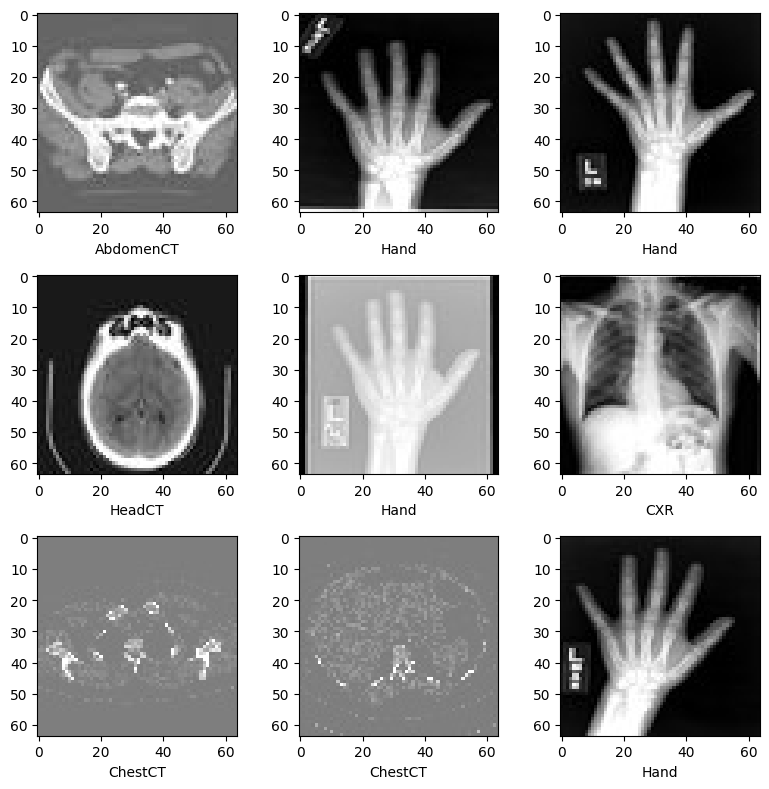

In [11]:
plt.subplots(3, 3, figsize=(8, 8))#建立包含 3×3 子窗口，尺寸为8×8英寸的图像窗口
for i, k in enumerate(np.random.randint(num_total, size=9)): # 从图像数据中随机抽取9个数
    im = PIL.Image.open(image_files_list[k]) # 利用PIL读取一个图像数据
    arr = np.array(im)# 转换为 ndarry数据类型
    plt.subplot(3, 3, i + 1)# 选中3×3窗口中的第i+1个窗口
    plt.xlabel(class_names[image_class[k]])# 再x坐标上写出该图像对应的种类
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)# 按照灰度显示图像，且仅显示0-255区域
#     plt.imshow(arr, cmap="gray")
plt.tight_layout()
plt.show()

因为数据集相对较大，一共有6万多张图片，因此训练集、验证集和测试集可以不按照7：2：1的方式划分。在本例程中，是按照8：1：1的方式来划分训练集、验证机和测试集的。对于分类问题，深度学习模型往往需要打乱数据顺序来消除数据先后顺序的影响。在实际应用中，不是在数据读入内存后再打乱顺序，而是通过对数据文件名进行随机排序。为了确保数据文件和标签在排序过程中保证对应关系不变，需要对序号（索引）序列进行操作。具体代码如下:

In [12]:
val_frac = 0.1 #设置验证集数据比例
test_frac = 0.1#设置测试集数据比例
length = len(image_files_list)#获得图像数据大小
indices = np.arange(length)# 获得0.。length-1的序号向量
np.random.shuffle(indices)# 打乱序号向量，消除数据先后顺序的影响
 
test_split = int(test_frac * length)#测试集大小
val_split = int(val_frac * length) + test_split#验证机大小
test_indices = indices[:test_split]#取得测试集序号序列
val_indices = indices[test_split:val_split]#取得验证集序号序列
train_indices = indices[val_split:]#剩下的就是训练集序号序列
 
train_x = [image_files_list[i] for i in train_indices]# 通过训练集序号序列，得到训练集文件名列表。
train_y = [image_class[i] for i in train_indices]# 通过训练集序号序列，得到训练集对应的标签列表。
val_x = [image_files_list[i] for i in val_indices]# 通过验证集序号序列，得到验证集文件名列表。
val_y = [image_class[i] for i in val_indices]# 通过验证集序号序列，得到训练集对应的标签列表。
test_x = [image_files_list[i] for i in test_indices]# 通过测试集序号序列，得到测试集文件名列表。
test_y = [image_class[i] for i in test_indices]# 通过测试集序号序列，得到测试集文件名列表。
# 打印出训练集、验证集和测试集数据长度
print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


MONAI中的transforms模块包含了所有的图像数据预处理操作，通过下面的设置，分别定义好了训练集变换train_transforms，验证集变换val_transforms，预测结果变换y_pred_trans，图像种类（标签）变换y_trans，只要正确引用下述变换，就可以对数据完成预先定义的预处理操作。具体代码及注释如下：


In [13]:
#对于训练集图像数据，进行图像数据载入、图像数据通道前移、灰度归一化，随机翻转、旋转和放大等操作，提升数据多样性
train_transforms = Compose(# 用Compose通过列表组合多个变换(预处理)操作
    [
        LoadImage(image_only=True),# 只读入图像数据
        EnsureChannelFirst(),# 确保把图形数据的通道放在第一位，满足torch框架要求
        ScaleIntensity(),# 把输入图像数据灰度值缩放到0-1范围内
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),# 50%概率产生-pi/12-pi/12角度的旋转，图像尺寸不变
        RandFlip(spatial_axis=0, prob=0.5),# 50%概率产生围绕纵轴的图像翻转
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),# 50%概率产生0.9-1.1的图像分辨率缩放
    ]
)
# 对验证集数据进行以下操作：图像数据载入、通道前移和灰度归一化操作
val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])
# 对于预测数据的操作为 softmax激活函数，因为标签种类数为6，需要采用softmax分类，得到属于每一类的概率值。
y_pred_trans = Compose([Activations(softmax=True)])
# 把数据转换为离散值，采用onehot编码
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

在训练深度模型前，需要定义训练、验证和测试数据集_ds及对应的数据加载器_loader。MONAI集成了pytorch框架方法，只需定义MedNISTDataset Class，实例化_ds数据集，再通过调用DataLoader得到对应的数据加载器_loader，就可以运行深度学习框架进行训练了。具体代码如下：355

In [14]:
class MedNISTDataset(torch.utils.data.Dataset):#定义MedNIST数据集
    def __init__(self, image_files, labels, transforms):# 初始化函数，获得图像文件名，标签和预处理函数
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
 
    def __len__(self): # 返回数据
        return len(self.image_files) # 返回数据文件名的数量，即图像数据长度
 
    def __getitem__(self, index): # 按照索引，返回图像数据和对应的标签
        return self.transforms(self.image_files[index]), self.labels[index]
 
# 把训练集文件名列表和标签列表，以及定义的变换作为参数调用，用MedNISTDataset实例化train_ds数据集
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
# 用DataLoader得到训练集数据加载器，批量大小为300（batch_size决定），打乱顺序（shuffle决定），通过10个线程同时加载数据。
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)
# 把验证集文件名列表和标签列表，以及定义的变换作为参数，通过MedNISTDataset实例化为val_ds数据集
val_ds = MedNISTDataset(val_x, val_y, val_transforms)
# 用DataLoader得到验证数据加载器，其数据集为val_ds,批量大小300（batch_size），通过10个线程加载数据
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)
# 把测试集文件名列表和标签列表、以及验证集变换（只进行灰度归一化）作为参数调用，用MedNISTDataset生成测试数据集
test_ds = MedNISTDataset(test_x, test_y, val_transforms)
# 用DataLoader得到测试数据加载器，其数据集为test_ds,批量大小300（batch_size），通过10个线程加载数据
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


在完成数据加载器的定义之后，就可以开始深度学习模型设计、策略和优化算法选择了。模型选择稠密神经网络DenseNet121，损失函数选择交叉熵，优化算法选择Adam。代码及注释如下：


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#如果平台由gpu，就设置为gpu计算
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)#选择DenseNet121模型
loss_function = torch.nn.CrossEntropyLoss()#损失函数选择交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), 1e-5)#优化算法为Adam
max_epochs = 4#对所有数据训练四次，也可以增加训练次数
val_interval = 1#每次epoch后都会尽心验证
auc_metric = ROCAUCMetric()#评估指标为ROC曲线下面积，越接近1说明模型效果越好。

准备好了数据加载器、定义好模型，并设置好损失函数及优化算法之后，就可以开始模型训练了。模型训练也需要设置一些参数，比如批量大小（batch_size）、训练循环次数（epochs），以及评价训练效果的性能指标。代码及注释如下：

In [16]:
best_metric = -1 # 定义最佳测量值变量
best_metric_epoch = -1# 定义最佳训练循环次数变量
epoch_loss_values = []#定义训练损失值变量
metric_values = []#定义测量值列表
writer = SummaryWriter()#记录训练过程指标，用于可视化训练过程
 
for epoch in range(max_epochs):#根据训练循环次数开始训练
    print("-" * 10)#每次循环，打印10个_
    print(f"epoch {epoch + 1}/{max_epochs}")#f字串，打印当前属于第几次训练循环
    model.train()#初始化模型训练
    epoch_loss = 0#初始化训练损失
    step = 0#当前循环，批量计数为0
    for batch_data in train_loader:#通过训练数据加载器获得批量数据，300组数据
        step += 1#批量计数加1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)# 批量图像和标签数据分别放入设备
        optimizer.zero_grad()#梯度初始化
        outputs = model(inputs)#前向传播
        loss = loss_function(outputs, labels)#计算损失函数
        loss.backward()#反向传播求梯度
        optimizer.step()#更新权重
        epoch_loss += loss.item()#叠加损失值
        #打印当前批次和总批次数，以及当前批量数据的损失
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size #每次训练数据循环的批次数目，等于训练数据//批量大小
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)#
    epoch_loss /= step # 当前批次的平均损失
    epoch_loss_values.append(epoch_loss)#当前批次的平均损失添加近列表
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")#打印平均损失
 
    if (epoch + 1) % val_interval == 0:# 根据val_interval值，进行验证
        model.eval()#初始化评估函数
        with torch.no_grad():# 评估时，不要计算梯度
            y_pred = torch.tensor([], dtype=torch.float32, device=device)#定义预测向量
            y = torch.tensor([], dtype=torch.long, device=device)#定义标签向量
            for val_data in val_loader:#按照批量要求读入验证数据与标签
                val_images, val_labels = (#把批量验证数据和标签放入设备
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)# 对批量预测数据进行拼接
                y = torch.cat([y, val_labels], dim=0)# 对批量标签数据进行拼接，直至循环完毕
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]#对标签数据变换为one-hot编码
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]#预测数据，形成预测数据列表
            auc_metric(y_pred_act, y_onehot)#计算模型预测的AUC值
            result = auc_metric.aggregate()# 对AUC值进行累加
            auc_metric.reset()
            del y_pred_act, y_onehot # 删除预测数据列表和测试one-hot列表
            metric_values.append(result) # 将AUC结果添加到测量值列表上
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:#根据最佳AUC值，保存模型参数
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print( # 每次训练循环结束后，打印相关信息
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)#保存验证精度
#所有训练循环结束后，打印最佳测量参数，及其对应的训练循环次数
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close() #关闭训练过程参数记录
print(f"Train finished!")#显示循环结束

----------
epoch 1/4


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/157, train_loss: 1.7861
2/157, train_loss: 1.7579
3/157, train_loss: 1.7349
4/157, train_loss: 1.7121
5/157, train_loss: 1.6764
6/157, train_loss: 1.6536
7/157, train_loss: 1.6250
8/157, train_loss: 1.5943
9/157, train_loss: 1.5656
10/157, train_loss: 1.5610
11/157, train_loss: 1.5324
12/157, train_loss: 1.5088
13/157, train_loss: 1.4761
14/157, train_loss: 1.4483
15/157, train_loss: 1.4450
16/157, train_loss: 1.4296
17/157, train_loss: 1.4002
18/157, train_loss: 1.3933
19/157, train_loss: 1.3492
20/157, train_loss: 1.3566
21/157, train_loss: 1.2952
22/157, train_loss: 1.2912
23/157, train_loss: 1.2705
24/157, train_loss: 1.2809
25/157, train_loss: 1.2578
26/157, train_loss: 1.2741
27/157, train_loss: 1.2164
28/157, train_loss: 1.1884
29/157, train_loss: 1.1608
30/157, train_loss: 1.1257
31/157, train_loss: 1.1460
32/157, train_loss: 1.1168
33/157, train_loss: 1.0903
34/157, train_loss: 1.0716
35/157, train_loss: 1.0851
36/157, train_loss: 1.0641
37/157, train_loss: 1.0576
38/157, tr

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


158/157, train_loss: 0.3812
epoch 1 average loss: 0.7275
saved new best metric model
current epoch: 1 current AUC: 0.9980 current accuracy: 0.9608 best AUC: 0.9980 at epoch: 1
----------
epoch 2/4
1/157, train_loss: 0.2629
2/157, train_loss: 0.2664
3/157, train_loss: 0.2203
4/157, train_loss: 0.2463
5/157, train_loss: 0.2195
6/157, train_loss: 0.2153
7/157, train_loss: 0.2265
8/157, train_loss: 0.2131
9/157, train_loss: 0.2252
10/157, train_loss: 0.2397
11/157, train_loss: 0.2283
12/157, train_loss: 0.2232
13/157, train_loss: 0.2403
14/157, train_loss: 0.2052
15/157, train_loss: 0.2042
16/157, train_loss: 0.1904
17/157, train_loss: 0.2335
18/157, train_loss: 0.1843
19/157, train_loss: 0.2283
20/157, train_loss: 0.2128
21/157, train_loss: 0.1930
22/157, train_loss: 0.2029
23/157, train_loss: 0.2051
24/157, train_loss: 0.1891
25/157, train_loss: 0.1809
26/157, train_loss: 0.2091
27/157, train_loss: 0.1862
28/157, train_loss: 0.2159
29/157, train_loss: 0.1921
30/157, train_loss: 0.1739
31

  在上面的训练代码中，我们通过epoch_loss_values变量和metric_values变量记录了每次训练循环过程的损失值和性能指标，通过matplotlib.pyplot软件包的plot命令，可以绘制出损失和性能指标变化曲线，能够形象地展现出损失及性能指标与训练循环次数的关系。代码及注解如下所示：355

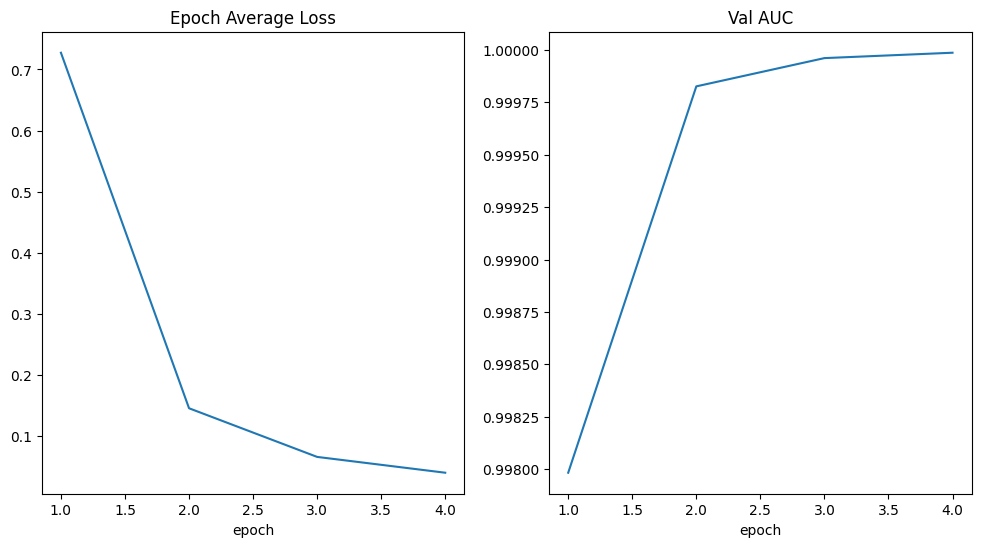

In [17]:
plt.figure("train", (12, 6))#新建一个绘图窗口，尺寸为12×6英寸
plt.subplot(1, 2, 1)#打开左边第一个绘图区
plt.title("Epoch Average Loss")#绘图区名字设置为"Epoch Average Loss"
x = [i + 1 for i in range(len(epoch_loss_values))]# 通过列表表达式，得到epoch_loss_values长度列表
y = epoch_loss_values# y轴就是epoch_loss_values值
plt.xlabel("epoch")#横坐标名称为epoch
plt.plot(x, y)#以x和y数据，绘制曲线
plt.subplot(1, 2, 2)#开开右边第二个绘图区
plt.title("Val AUC")#设置绘图区名称为 "Val AUC"
x = [val_interval * (i + 1) for i in range(len(metric_values))]# 通过列表表达式，得到metric_values长度列表
y = metric_values #y轴数据为metric_values
plt.xlabel("epoch")# x 轴标号为“epoch”
plt.plot(x, y) #绘制曲线
plt.show() # 显示图像

 深度学习模型的训练离不开训练集、验证集和测试集，训练集用来优化模型参数，验证集确定最佳模型参数，而测试集则用来评估模型的泛化能力。测试代码及注解如下：

In [18]:
# 加载预训练模型权重
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), weights_only=True))
# 设置模型评估模式，不更新权重
model.eval()
y_true = []#设置真实值列表
y_pred = []#设置预测值列表
with torch.no_grad():# 仅进行前向传播，不计算梯度，节约内存开销，提高计算速度
    for test_data in test_loader: # 批量加载数据
        test_images, test_labels = (
            test_data[0].to(device),# 把测试图像加载到设备，
            test_data[1].to(device),# 把标签数据加载到设备
        )
        pred = model(test_images).argmax(dim=1)# 对测试图像数据进行预测，并把结果转换为最大概率对应的序号值
        for i in range(len(pred)):#遍历测试序列每一个元素
            y_true.append(test_labels[i].item())# 添加测试标签到y_true列表中
            y_pred.append(pred[i].item())#添加预测值到y_pred列表中

得到了测试标签序列y_true和预测序列y_pred之后，可以利用sklearn中的函数很方便第计算出混淆矩阵，从而更全面地评估训练模型的泛化能力。具体代码及解释如下：


In [19]:
# 生成分类评价报告，y_true是标签列表，y_pred是预测值列表，target_names是标签分类列表，digits决定小数点后保留位数
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9940    0.9970    0.9955       995
   BreastMRI     0.9954    0.9909    0.9932       880
         CXR     0.9990    0.9980    0.9985       982
     ChestCT     0.9902    1.0000    0.9951      1014
        Hand     0.9981    0.9924    0.9952      1048
      HeadCT     0.9969    0.9949    0.9959       976

    accuracy                         0.9956      5895
   macro avg     0.9956    0.9955    0.9956      5895
weighted avg     0.9956    0.9956    0.9956      5895



从图中可以看出，模型分类的精确率(precision)都大于0.99，说明所有预测为真的样本中真样本所占的比例；召回率(recall)也大于0.99，说明所有真样本中预测为真的样本所占的比例，召回率越高说明漏诊率越低。这两个指标是相互制约，一般通过f1-score（精确率和召回率的调和平均数）综合反应模型的性能，模型对各种类型的f1-score都是大于0.99的，性能较好。355

In [20]:
import shutil
import os

# 定义源文件路径和目标文件路径
source_path = os.path.join(root_dir, 'best_metric_model.pth')
output_dir = './kaggle/working'  # Kaggle的输出目录

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 复制文件
target_path = os.path.join(output_dir, 'best_metric_model.pth')
shutil.copy(source_path, target_path)

print(f'File copied to {target_path}')

File copied to ./kaggle/working/best_metric_model.pth


In [21]:
# 检查写入权限
if os.access('./kaggle/working', os.W_OK):
    print("Write permission is granted.")
else:
    print("Write permission is denied.")

Write permission is granted.


In [22]:
import os

# 列出./kaggle/working目录下的所有文件
files_in_working = os.listdir('./kaggle/working')
print("Files in ./kaggle/working:", files_in_working)

Files in ./kaggle/working: ['best_metric_model.pth']


In [23]:
import os
file_size = os.path.getsize('./kaggle/working/best_metric_model.pth')
print(f"Size of best_metric_model.pth: {file_size} bytes")

Size of best_metric_model.pth: 28438034 bytes
